In [2]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [4]:
# Load data
df = pd.read_csv("pIC50_prediction/data/EGFR_compounds_lipinski.csv", index_col=0)
# df = df.reset_index(drop=True)

In [4]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (4635, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 4635 entries, 0 to 5567
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  4635 non-null   object 
 1   IC50                4635 non-null   float64
 2   units               4635 non-null   object 
 3   smiles              4635 non-null   object 
 4   pIC50               4635 non-null   float64
 5   molecular_weight    4635 non-null   float64
 6   n_hba               4635 non-null   int64  
 7   n_hbd               4635 non-null   int64  
 8   logp                4635 non-null   float64
 9   ro5_fulfilled       4635 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 366.6+ KB


In [5]:
# Look at head
df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


In [6]:
# Keep only the columns we want
chembl_df = df[["molecule_chembl_id", "smiles", "pIC50", "molecular_weight"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,molecular_weight
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607


In [7]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [8]:
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (4635, 5)


,molecule_chembl_id,smiles,pIC50,molecular_weight,fingerprints_df
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (3244,)
Shape of test data: (1391,)


In [10]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

In [11]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

NameError: name 'Sequential' is not defined

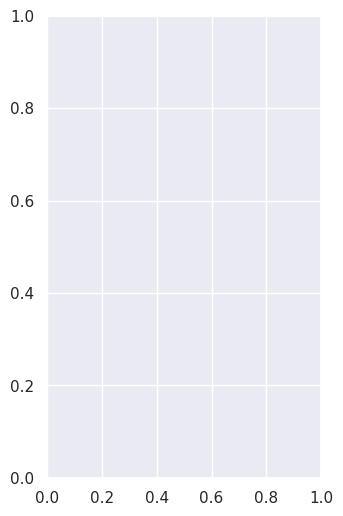

In [12]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

In [15]:
# Save the trained model
filepath = "checkpoints/best_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

In [ ]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

In [ ]:
# Load external/unlabeled data set
external_data = pd.read_csv(DATA / "test.csv", index_col=0)
external_data = external_data.reset_index(drop=True)
external_data.head()
# NBVAL_CHECK_OUTPUT

In [ ]:
# Convert SMILES strings to MACCS fingerprints
external_data["fingerprints_df"] = external_data["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", external_data.shape)
external_data.head(3)
# NBVAL_CHECK_OUTPUT

In [ ]:
# Load model
model = load_model(DATA / "ANN_model.hdf5", compile=False)

In [ ]:
# Prediction on external/unlabeled data
predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(3)

In [ ]:
# Save the predicted values in a csv file in the data folder
predicted_pIC50_df.to_csv(DATA / "predicted_pIC50_df.csv")

In [ ]:
# Select top 3 drugs
predicted_pIC50_df = pd.read_csv(DATA / "predicted_pIC50_df.csv", index_col=0)
top3_drug = predicted_pIC50_df.nlargest(3, "predicted_pIC50")
top3_drug

In [ ]:
# Draw the drug molecules
highest_pIC50 = predicted_pIC50_df["canonical_smiles"][top3_drug.index]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug["predicted_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_EGFR]

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values)